In [19]:
import warnings
warnings.filterwarnings('ignore')
import re
import math
import nltk
import numpy as np
from time import time
import pandas as pd
import pickle as pkl
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import chi2
from pylab import barh,plot,yticks,show,grid,xlabel,figure
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# read the data back in
heartDisease = pd.read_pickle("heartDisease.pkl")
X = heartDisease
X = np.array(X)

In [21]:
#original
print("Positive class (Presence of): {}".format((X[:,-1]==2).sum()))
print("Negative class (Absence of): {}".format((X[:,-1]==1).sum()))

Positive class (Presence of): 120
Negative class (Absence of): 150


In [13]:
#this cell was adapted from Iyer's notebook about running GridSearchCV with Logistic Regression
# choose a classifier
clf = XGBClassifier()


# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
          'max_depth': [1, 3, 6, 10, 25, 35, 50, 75],
          'n_estimators': [25, 50, 60, 75, 85, 100, 125, 150, 200],
          'reg_lambda': [1e-8, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 1, 5], 
          'reg_alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5],
          'gamma': [0, 0.01, 0.1, 0.2, 0.5, 1.0],
          'booster': ['gbtree', 'dart'],
          'objective': ['binary:logistic'],
             }

# run randomized search
n_iter_search = 200
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X[:,:-1], X[:,-1])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 26.68 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.859 (std: 0.053)
Parameters: {'reg_lambda': 0.05, 'reg_alpha': 1, 'objective': 'binary:logistic', 'n_estimators': 75, 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.059)
Parameters: {'reg_lambda': 0.01, 'reg_alpha': 1, 'objective': 'binary:logistic', 'n_estimators': 60, 'max_depth': 1, 'gamma': 0.2, 'booster': 'dart'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.054)
Parameters: {'reg_lambda': 5, 'reg_alpha': 1e-08, 'objective': 'binary:logistic', 'n_estimators': 75, 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.048)
Parameters: {'reg_lambda': 0.0001, 'reg_alpha': 0.0001, 'objective': 'binary:logistic', 'n_estimators': 75, 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.060)
Pa

In [22]:

# set number of iterations for bootstrapping
n_iterations = 1000
# set size of 
n_size = int(len(X))
# empty lists
results = []
cont = []
# values for learning rate
learning_rate = [0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.75, 1.0]

for t in range(len(learning_rate)):    
    truth = []
    xg_prediction = []
    print("XGBoost Classification Model ", t, ": Learning rate = " + str(learning_rate[t]))
    #set up model
    xg = XGBClassifier(learning_rate=learning_rate[t], reg_lambda=0.05, reg_alpha=1, objective='binary:logistic',
                      n_estimators=75, max_depth=1, gamma=1.0, booster='gbtree')
    #begin bootstrapping
    for i in range(n_iterations):
        trainX = resample(X, n_samples=n_size, replace=True)
        trainy = np.array([x for x in X if x.tolist() not in trainX.tolist()])
        truth.append(trainy[:,-1])
        xg.fit(trainX[:,:-1], trainX[:,-1])
        Y_hat = xg.predict(trainy[:,:-1])
        xg_prediction.append(Y_hat)
    truth = np.concatenate(truth, axis=0)
    xg_prediction = np.concatenate(xg_prediction, axis=0)
    test_results = np.sum(xg_prediction == truth) / len(truth)
    print("    Overall test accuracy: %.2f %%" % (test_results * 100))
    xg = xg.fit(X[:,:-1], X[:,-1])
    Y_hat = xg.predict(X[:,:-1])
    train_results = np.sum(Y_hat == X[:,-1]) / len(X[:,-1])
    print("    Overall training accuracy: %.2f %%" % (train_results * 100))
    results.append([train_results, test_results])   
    cont.append([truth, xg_prediction])    

    

XGBoost Classification Model  0 : Learning rate = 0.01
    Overall test accuracy: 77.03 %
    Overall training accuracy: 85.56 %
XGBoost Classification Model  1 : Learning rate = 0.1
    Overall test accuracy: 82.51 %
    Overall training accuracy: 87.04 %
XGBoost Classification Model  2 : Learning rate = 0.2
    Overall test accuracy: 82.46 %
    Overall training accuracy: 87.78 %
XGBoost Classification Model  3 : Learning rate = 0.3
    Overall test accuracy: 82.54 %
    Overall training accuracy: 88.15 %
XGBoost Classification Model  4 : Learning rate = 0.35
    Overall test accuracy: 82.25 %
    Overall training accuracy: 87.78 %
XGBoost Classification Model  5 : Learning rate = 0.4
    Overall test accuracy: 82.44 %
    Overall training accuracy: 87.41 %
XGBoost Classification Model  6 : Learning rate = 0.5
    Overall test accuracy: 82.39 %
    Overall training accuracy: 88.52 %
XGBoost Classification Model  7 : Learning rate = 0.75
    Overall test accuracy: 81.89 %
    Overall 

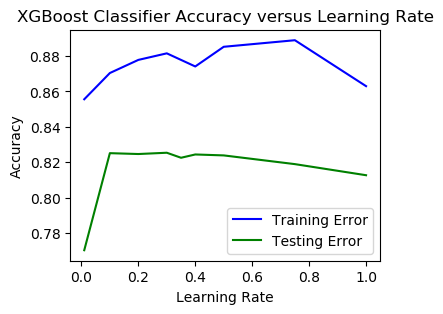

In [23]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

plt.rcdefaults()
plt.figure(figsize=(4,3))
trainAcc = plt.plot(learning_rate, tracc, '-b', label='Training Error')
testACC = plt.plot(learning_rate, tstacc, '-g', label='Testing Error')
plt.title("XGBoost Classifier Accuracy versus Learning Rate")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.legend(loc="best")
plt.show(block=False)

In [24]:
model = input("Enter Best Model: ")
best = cont[int(model)]
xg_ct = pd.crosstab(best[1], best[0], margins=True)
xg_ct.columns = ["-'ve HD", "+'ve HD", "Total"]
xg_ct.index = ["-'ve HD", "+'ve HD", "Total"]
print()
print("Logistic Regression")
print(xg_ct)
print()

Enter Best Model: 3

Logistic Regression
         -'ve HD  +'ve HD  Total
-'ve HD    47711     9938  57649
+'ve HD     7396    34218  41614
Total      55107    44156  99263



In [25]:
Sens = xg_ct.iloc[1][1]/xg_ct.iloc[2][1]
Spec = xg_ct.iloc[0][0]/xg_ct.iloc[2][0]
PPV = xg_ct.iloc[1][1]/xg_ct.iloc[1][2]
NPV = xg_ct.iloc[0][0]/xg_ct.iloc[0][2]
ACC = (xg_ct.iloc[0][0] + xg_ct.iloc[1][1]) / xg_ct.iloc[2][2]
print("Logistic Regression: Sensitivity: %.2f Specificity: %.2f PPV: %.2f NPV: %.2f Accuracy: %.2f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Logistic Regression: Sensitivity: 0.77 Specificity: 0.87 PPV: 0.82 NPV: 0.83 Accuracy: 0.83


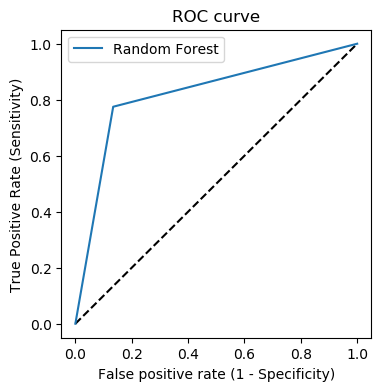

AUC =  0.820361349551863


In [26]:
xg_fpr, xg_tpr, xg_thresholds = roc_curve(best[0], best[1], pos_label=2)
roc_auc = auc(xg_fpr, xg_tpr)
plt.rcdefaults()
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot( xg_fpr, xg_tpr, label='Random Forest')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)